[![colab-logo](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/japan-medical-ai/medical-ai-course-materials/blob/master/notebooks/Sequential_Data_Analysis_with_Deep_Learningt a.ipynb)

# 実践編: ディープラーニングを使ったモニタリングデータの時系列解析

健康意識の高まりや運動人口の増加に伴って，活動量計などのウェアラブルデバイスが普及し始めています．センサーデバイスから心拍数などの情報を取得することで，リアルタイムに健康状態をモニタリングできる可能性があることから，近年ではヘルスケア領域での活用事例も増えてきています．2018年2月には，Cardiogram社とカリフォルニア大学が共同研究の成果を発表し，心拍数データに対してDeep Learningを適用することで，高精度に糖尿病予備群を予測可能であることを報告し，大きな注目を集めました．また，Apple Watch Series 4には心電図作成の機能が搭載されるなど，センサーデバイスも進歩を続け，より精緻な情報が取得できるようになってきています．こうした背景において，モニタリングデータを収集・解析し，健康管理に繋げていく取り組みは今後益々盛んになっていくものと考えられます．


本章では，心電図の信号波形データを対象として，不整脈を検出する問題に取り組みます．

## 環境構築

はじめに, 下記の必要ライブラリをインストールします.

* Cupy
* Chainer
* Scipy
* Matplotlib
* Seaborn
* Pandas
* WFDB
* Scikit-learn
* Imbalanced-learn

以下のセルを実行 (Shift + Enter) して下さい. 

In [67]:
!set -ex
!apt -y -q install cuda-libraries-dev-9-2 tree
!pip install cupy-cuda92==5.0.0
!pip install chainer==5.0.0
!pip install scipy==0.19.1 matplotlib==2.1.2 seaborn==0.7.1 pandas==0.22.0 wfdb==2.2.1
!pip install imbalanced-learn==0.4.3

Reading package lists...
Building dependency tree...
Reading state information...
tree is already the newest version (1.7.0-5).
cuda-libraries-dev-9-2 is already the newest version (9.2.148-1).
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


インストールが完了したら以下のセルを実行して，各ライブラリのインポート，及びバージョン確認を行って下さい.

In [68]:
import os
import random
import numpy as np
import cupy
import chainer
import scipy
import pandas as pd
import matplotlib
import seaborn as sn
import wfdb
import sklearn
import imblearn

chainer.print_runtime_info()
print("Scipy: ", scipy.__version__)
print("Pandas: ", pd.__version__)
print("Matplotlib: ", matplotlib.__version__)
print("Seaborn: ", sn.__version__)
print("WFDB: ", wfdb.__version__)
print("Scikit-learn: ", sklearn.__version__)
print("Imbalanced-learn: ", imblearn.__version__)

Platform: Linux-4.14.65+-x86_64-with-Ubuntu-18.04-bionic
Chainer: 5.0.0
NumPy: 1.14.6
CuPy:
  CuPy Version          : 5.0.0
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 9020
  CUDA Driver Version   : 9020
  CUDA Runtime Version  : 9020
  cuDNN Build Version   : 7201
  cuDNN Version         : 7201
  NCCL Build Version    : 2213
iDeep: Not Available
Scipy:  1.1.0
Pandas:  0.22.0
Matplotlib:  2.1.2
Seaborn:  0.7.1
WFDB:  2.2.1
Scikit-learn:  0.20.0
Imbalanced-learn:  0.4.3


## 心電図(ECG)と不整脈診断について

心電図(Electrocardiogram, ECG)は，心筋の活動によって生じる電気的変動を記録したものであり，心電図検査は不整脈の診断に広く利用されている他，虚血性心疾患や呼吸器疾患などの診断にも利用可能です[[文献1](https://en.wikipedia.org/wiki/Electrocardiography), [文献2](https://www.ncc.go.jp/jp/ncch/d001/gairai/kensa/seirikensa/index.html), [文献3](https://www.ningen-dock.jp/wp/wp-content/uploads/2013/09/d4bb55fcf01494e251d315b76738ab40.pdf)]．

標準的な心電図は，手足からとる心電図（四肢誘導）として，双極誘導（$Ⅰ$，$Ⅱ$，$Ⅲ$），及び単極誘導（$aV_R$，$aV_L$，$aV_F$）の6誘導，胸部からとる心電図（胸部誘導）として，$V_1$，$V_2$，$V_3$，$V_4$，$V_5$，$V_6$の6誘導，計12誘導から成ります．このうち，特に不整脈のスクリーニングを行う際には，$Ⅱ$誘導と$V_1$誘導に注目して診断が行われるのが一般的とされています．

心臓が正常な状態では，ECGにおいては規則的な波形が観測され，これを正常洞調律 (Normal sinus rhythm, NSR)といいます．

具体的には，以下の3つの主要な波形で構成されており，

1. P波：心房の脱分極（心房の興奮）
1. QRS波：心室の脱分極（心室の興奮）
1. T波：心室の再分極（心室興奮の収まり）

の順番で，下図のような波形が観測されます．

![sinus_rhythm](https://github.com/japan-medical-ai/medical-ai-course-materials/raw/master/notebooks/images/monitoring/sinus_rhythm.png)

(図は[[文献1](https://en.wikipedia.org/wiki/Electrocardiography)]より抜粋)

こうした規則的な波形に乱れが生じ，調律に異常があると判断された場合，不整脈などの疑いがあるため，診断が行われることになります．

## 使用するデータセット

ここでは，ECGの公開データとして有名な[MIT-BIH Arrhythmia Database (mitdb)](https://www.physionet.org/physiobank/database/mitdb/)を使用します．

47名の患者から収集した48レコードが登録されており，各レコードファイルには約30分間の2誘導($II$，$V_1$)のシグナルデータが格納されています．また，各R波のピーク位置に対してアノテーションが付与されています．(データとアノテーションの詳細については[こちら](https://www.physionet.org/physiobank/database/html/mitdbdir/intro.htm)を御覧ください．)

データベースは[PhysioNet](https://www.physionet.org/)によって管理されており，ダウンロードや読み込み用のPythonパッケージが提供されているので，今回はそちらを利用してデータを入手します．

In [0]:
dataset_root = './dataset'
download_dir = os.path.join(dataset_root, 'download')

まずはmitdbデータベースをダウンロードしましょう．
※実行時にエラーが出た場合は，再度実行して下さい．

In [70]:
wfdb.dl_database('mitdb', dl_dir=download_dir)

Finished downloading files


無事ダウンロードが完了すると， `Finished downloading files` というメッセージが表示されます．

ファイル一覧を確認してみましょう．

In [71]:
print(sorted(os.listdir(download_dir)))

['100.atr', '100.dat', '100.hea', '101.atr', '101.dat', '101.hea', '102.atr', '102.dat', '102.hea', '103.atr', '103.dat', '103.hea', '104.atr', '104.dat', '104.hea', '105.atr', '105.dat', '105.hea', '106.atr', '106.dat', '106.hea', '107.atr', '107.dat', '107.hea', '108.atr', '108.dat', '108.hea', '109.atr', '109.dat', '109.hea', '111.atr', '111.dat', '111.hea', '112.atr', '112.dat', '112.hea', '113.atr', '113.dat', '113.hea', '114.atr', '114.dat', '114.hea', '115.atr', '115.dat', '115.hea', '116.atr', '116.dat', '116.hea', '117.atr', '117.dat', '117.hea', '118.atr', '118.dat', '118.hea', '119.atr', '119.dat', '119.hea', '121.atr', '121.dat', '121.hea', '122.atr', '122.dat', '122.hea', '123.atr', '123.dat', '123.hea', '124.atr', '124.dat', '124.hea', '200.atr', '200.dat', '200.hea', '201.atr', '201.dat', '201.hea', '202.atr', '202.dat', '202.hea', '203.atr', '203.dat', '203.hea', '205.atr', '205.dat', '205.hea', '207.atr', '207.dat', '207.hea', '208.atr', '208.dat', '208.hea', '209.atr'

ファイル名の数字はレコードIDを表しています．各レコードには3種類のファイルがあり，
- `.dat` : シグナル（バイナリ形式）
- `.atr` : アノテーション（バイナリ形式）
- `.hea` : ヘッダ（バイナリファイルの読み込みに必要）

となっています．

## データ前処理

ダウンロードしたファイルを読み込み，機械学習モデルへの入力形式に変換するデータ前処理について説明します．

本節では，以下の手順で前処理を行います．

1. レコードIDを事前に 学習用 / 評価用 に分割
    - 48レコードのうち，
        - ID =（102, 104, 107, 217）のシグナルはペースメーカーの拍動が含まれるため除外します．
        - ID = 114のシグナルは波形が反転しているため，今回は除外します．
        - ID = （201, 202）は同一の患者から得られたデータのため，202を除外します．
    - 上記を除く計42レコードを，学習用とテスト用に分割します（分割方法は[[文献4](https://ieeexplore.ieee.org/document/1306572)]を参考）．
1. シグナルファイル (.dat) の読み込み
    - $Ⅱ$誘導シグナルと$V_1$誘導シグナルが格納されていますが，今回は$Ⅱ$誘導のみ利用します．
    - サンプリング周波数は360 Hz なので，1秒間に360回のペースで，数値が記録されていることになります．
1.  アノテーションファイル (.atr) の読み込み
    - 各R波ピークの位置 (positions) と，そのラベル (symbols) を取得します．
1. シグナルの正規化
    - 平均0，分散1になるように変換を行います．
1. シグナルの分割 (segmentation)
    - 各R波ピークを中心として2秒間(前後1秒ずつ)の断片を切り出していきます．
1. 分割シグナルへのラベル付与
    - 各R波ピークに付与されているラベルを，下表(※)に従って集約し，今回の解析では正常拍動 (Normal)，及び心室異所性拍動 (VEB) のラベルが付与されている分割シグナルのみ学習・評価に利用します．
    
※ Association for the Advancement of Medical Instrumentation (AAMI)が推奨している基準([[文献4](https://ieeexplore.ieee.org/document/1306572)])で，5種類に大別して整理されています．

![aami_standard](https://github.com/japan-medical-ai/medical-ai-course-materials/raw/master/notebooks/images/monitoring/aami_standard.png)

(表は[[文献5](https://arxiv.org/abs/1810.04121)]より抜粋)

まずは以下のセルを実行して，データ前処理クラスを定義しましょう．

In [0]:
class BaseECGDatasetPreprocessor(object):

    def __init__(
            self,
            dataset_root,
            window_size=720,  # 2 seconds
    ):
        self.dataset_root = dataset_root
        self.download_dir = os.path.join(self.dataset_root, 'download')
        self.window_size = window_size
        self.sample_rate = 360.
        self.train_record_list = [
            '101', '106', '108', '109', '112', '115', '116', '118', '119', '122',
            '124', '201', '203', '205', '207', '208', '209', '215', '220', '223', '230'
        ]
        self.test_record_list = [
            '100', '103', '105', '111', '113', '117', '121', '123', '200', '210',
            '212', '213', '214', '219', '221', '222', '228', '231', '232', '233', '234'
        ]
        # annotation
        self.labels = ['N', 'V']
        self.valid_symbols = ['N', 'L', 'R', 'e', 'j', 'V', 'E']
        self.label_map = {
            'N': 'N', 'L': 'N', 'R': 'N', 'e': 'N', 'j': 'N',
            'V': 'V', 'E': 'V'
        }

    def _load_data(
            self,
            base_record,
            channel=0  # [0, 1]
    ):
        record_name = os.path.join(self.download_dir, str(base_record))
        # read dat file
        signals, fields = wfdb.rdsamp(record_name)
        assert fields['fs'] == self.sample_rate
        # read annotation file
        annotation = wfdb.rdann(record_name, 'atr')
        symbols = annotation.symbol
        positions = annotation.sample
        return signals[:, channel], symbols, positions

    def _normalize_signal(
            self,
            signal,
            method='std'
    ):
        if method == 'minmax':
            min_val = np.min(signal)
            max_val = np.max(signal)
            return (signal - min_val) / (max_val - min_val)
        elif method == 'std':
            signal -= np.mean(signal) / np.std(signal)
            return signal
        else:
            raise ValueError("Invalid value: {}".format(method))

    def _segment_data(
            self,
            signal,
            symbols,
            positions
    ):
        X = []
        y = []
        sig_len = len(signal)
        for i in range(len(symbols)):
            start = positions[i] - self.window_size // 2
            end = positions[i] + self.window_size // 2
            if symbols[i] in self.valid_symbols and start >= 0 and end <= sig_len:
                segment = signal[start:end]
                assert len(segment) == self.window_size, "Invalid length"
                X.append(segment)
                y.append(self.labels.index(self.label_map[symbols[i]]))
        return np.array(X), np.array(y)

    def preprocess_dataset(
            self,
            normalize=True
    ):
        # prepare training dataset
        self._preprocess_dataset_core(self.train_record_list, "train", normalize)
        # prepare test dataset
        self._preprocess_dataset_core(self.test_record_list, "test", normalize)

    def _preprocess_dataset_core(
            self,
            record_list,
            mode="train",
            normalize=True
    ):
        Xs, ys = [], []
        for i in range(len(record_list)):
            signal, symbols, positions = self._load_data(record_list[i])
            if normalize:
                signal = self._normalize_signal(signal)
            X, y = self._segment_data(signal, symbols, positions)
            Xs.append(X)
            ys.append(y)
        os.makedirs(os.path.join(self.dataset_root, 'preprocessed', mode), exist_ok=True)
        np.save(os.path.join(self.dataset_root, 'preprocessed', mode, "X.npy"),
                np.vstack(Xs))
        np.save(os.path.join(self.dataset_root, 'preprocessed', mode, "y.npy"),
                np.concatenate(ys))


データ保存先のrootディレクトリ(dataset_root)を指定し， `preprocess_dataset()` を実行することで，前処理後のデータがNumpy Array形式で所定の場所に保存されます．

In [0]:
BaseECGDatasetPreprocessor(dataset_root).preprocess_dataset()

実行後，以下のファイルが保存されていることを確認しましょう．
* train/X.npy : 学習用シグナル
* train/y.npy : 学習用ラベル
* test/X.npy : 評価用シグナル
* test/y.npy : 評価用ラベル

In [74]:
!tree ./dataset/preprocessed

./dataset/preprocessed
├── test
│   ├── X.npy
│   └── y.npy
└── train
    ├── X.npy
    └── y.npy

2 directories, 4 files


次に，保存したファイルを読み込み，中身を確認してみましょう．

In [0]:
X_train = np.load(os.path.join(dataset_root, 'preprocessed', 'train', 'X.npy'))
y_train = np.load(os.path.join(dataset_root, 'preprocessed', 'train', 'y.npy'))
X_test = np.load(os.path.join(dataset_root, 'preprocessed', 'test', 'X.npy'))
y_test = np.load(os.path.join(dataset_root, 'preprocessed', 'test', 'y.npy'))

データセットのサンプル数はそれぞれ以下の通りです．
* 学習用 : 47738個
* 評価用 : 45349個

各シグナルデータは，2 (sec) * 360 (Hz) = 720次元ベクトルとして表現されています．

In [76]:
print("X_train.shape = ", X_train.shape, "\ty_train.shape = ", y_train.shape)
print("X_test.shape = ", X_test.shape, "\ty_test.shape = ", y_test.shape)

X_train.shape =  (47738, 720) 	y_train.shape =  (47738,)
X_test.shape =  (45349, 720) 	y_test.shape =  (45349,)


各ラベルはインデックスで表現されており，
* 0 : 正常拍動 (Normal)
* 1 : 心室異所性拍動 (VEB)

となっています．

学習用データセットに含まれている各ラベル毎のサンプル数をカウントしてみましょう．

In [77]:
uniq_train, counts_train = np.unique(y_train, return_counts=True)
print("y_train count each labels: ", dict(zip(uniq_train, counts_train)))

y_train count each labels:  {0: 43995, 1: 3743}


評価用データについても同様にラベル毎のサンプル数をカウントします．

In [78]:
uniq_test, counts_test = np.unique(y_test, return_counts=True)
print("y_test count each labels: ", dict(zip(uniq_test, counts_test)))

y_test count each labels:  {0: 42149, 1: 3200}


学習用データ，評価用データ共に，VEBサンプルは10%未満であり，大多数は正常拍動サンプルであることが分かります．

次に，正常拍動，及びVEBのシグナルデータを可視化してみましょう．

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

正常拍動の例を図示したものが以下になります．

P波 - QRS波 - T波が規則的に出現していることが確認できます．

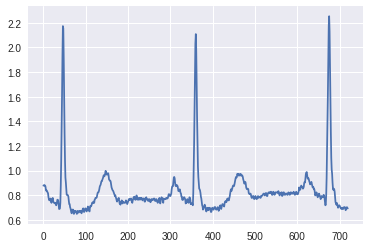

In [80]:
idx_n = np.where(y_train == 0)[0]
plt.plot(X_train[idx_n[0]])

一方でVEBの波形は規則性が乱れ，R波ピークの形状やピーク間距離も正常例とは異なる性質を示していることが分かります．

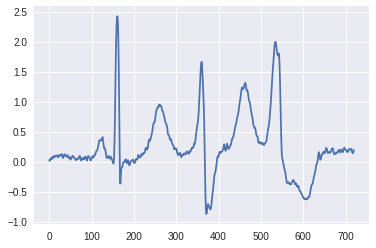

In [81]:
idx_s = np.where(y_train == 1)[0]
plt.plot(X_train[idx_s[0]])

本章の目的は，ECGシグナル特徴をうまく捉え，新たな波形サンプルに対しても高精度に正常/異常を予測するモデルを構築することです．

次節では，深層学習を利用したモデル構築について説明していきます．

## 深層学習を用いた時系列データ解析

### 学習

まずはじめに，前節で準備した前処理済みデータをChainerで読み込むためのデータセットクラスを定義します．

In [0]:
class ECGDataset(chainer.dataset.DatasetMixin):

    def __init__(
            self,
            path
    ):
        if os.path.isfile(os.path.join(path, 'X.npy')):
            self.X = np.load(os.path.join(path, 'X.npy'))
        else:
            raise FileNotFoundError("{}/X.npy not found.".format(path))
        if os.path.isfile(os.path.join(path, 'y.npy')):
            self.y = np.load(os.path.join(path, 'y.npy'))
        else:
            raise FileNotFoundError("{}/y.npy not found.".format(path))

    def __len__(self):
        return len(self.X)

    def get_example(self, i):
        return self.X[None, i].astype(np.float32), self.y[i]


続いて，学習（＋予測）に利用するネットワーク構造を定義します．

今回は，画像認識タスクで有名な，CNNベースのResNet34と同様のネットワーク構造を利用します．
ただし，入力シグナルは1次元配列であることから，画像解析等で一般的に利用される2D Convolutionではなく，前章の遺伝子解析と同様，1D Convolutionを利用します．

In [0]:
import chainer.functions as F
import chainer.links as L
from chainer import reporter
from chainer import Variable
      
    
class BaseBlock(chainer.Chain):

    def __init__(
            self,
            channels,
            stride=1,
            dilate=1
    ):
        self.stride = stride
        super(BaseBlock, self).__init__()
        with self.init_scope():
            self.c1 = L.ConvolutionND(1, None, channels, 3, stride, dilate, dilate=dilate)
            self.c2 = L.ConvolutionND(1, None, channels, 3, 1, dilate, dilate=dilate)
            if stride > 1:
                self.cd = L.ConvolutionND(1, None, channels, 1, stride, 0)
            self.b1 = L.BatchNormalization(channels)
            self.b2 = L.BatchNormalization(channels)

    def __call__(self, x):
        h = F.relu(self.b1(self.c1(x)))
        if self.stride > 1:
            res = self.cd(x)
        else:
            res = x
        h = res + self.b2(self.c2(h))
        return F.relu(h)


class ResBlock(chainer.Chain):

    def __init__(
            self,
            channels,
            n_block,
            dilate=1
    ):
        self.n_block = n_block
        super(ResBlock, self).__init__()
        with self.init_scope():
            self.b0 = BaseBlock(channels, 2, dilate)
            for i in range(1, n_block):
                bx = BaseBlock(channels, 1, dilate)
                setattr(self, 'b{}'.format(str(i)), bx)

    def __call__(self, x):
        h = self.b0(x)
        for i in range(1, self.n_block):
            h = getattr(self, 'b{}'.format(str(i)))(h)
        return h


class ResNet34(chainer.Chain):

    def __init__(self):
        super(ResNet34, self).__init__()
        with self.init_scope():
            self.conv1 = L.ConvolutionND(1, None, 64, 7, 2, 3)
            self.bn1 = L.BatchNormalization(64)
            self.resblock0 = ResBlock(64, 3)
            self.resblock1 = ResBlock(128, 4)
            self.resblock2 = ResBlock(256, 6)
            self.resblock3 = ResBlock(512, 3)
            self.fc = L.Linear(None, 2)

    def __call__(self, x):
        h = F.relu(self.bn1(self.conv1(x)))
        h = F.max_pooling_nd(h, 3, 2)
        for i in range(4):
            h = getattr(self, 'resblock{}'.format(str(i)))(h)
        h = F.average(h, axis=2)
        h = self.fc(h)
        return h
      

class Classifier(chainer.Chain):

    def __init__(
            self,
            predictor,
            lossfun=F.softmax_cross_entropy
    ):
        super(Classifier, self).__init__()
        with self.init_scope():
            self.predictor = predictor
            self.lossfun = lossfun

    def __call__(self, *args):
        assert len(args) >= 2
        x = args[:-1]
        t = args[-1]
        y = self.predictor(*x)

        # loss
        loss = self.lossfun(y, t)
        with chainer.no_backprop_mode():
            # other metrics
            accuracy = F.accuracy(y, t)
        # reporter
        reporter.report({'loss': loss}, self)
        reporter.report({'accuracy': accuracy}, self)

        return loss

    def predict(self, x):
        with chainer.function.no_backprop_mode(), chainer.using_config('train', False):
            x = Variable(self.xp.asarray(x, dtype=self.xp.float32))
            y = self.predictor(x)
            return y
          

学習を実行するための準備として，以下の関数を用意します．
- `create_train_dataset()`：学習用データセットを `ECGDataset` クラスに渡す
- `create_trainer()`：学習に必要な設定を行い，Trainerオブジェクトを作成


In [0]:
from chainer import optimizers
from chainer.optimizer import WeightDecay
from chainer.iterators import MultiprocessIterator
from chainer import training
from chainer.training import extensions
from chainer.training import triggers
from chainer.backends.cuda import get_device_from_id


def create_train_dataset(root_path):
    train_path = os.path.join(root_path, 'preprocessed', 'train')
    train_dataset = ECGDataset(train_path)

    return train_dataset


def create_trainer(
    batchsize, train_dataset, nb_epoch=1,
    device=0, lossfun=F.softmax_cross_entropy
):
    # setup model
    model = ResNet34()
    train_model = Classifier(model, lossfun=lossfun)

    # use Adam optimizer
    optimizer = optimizers.Adam(alpha=0.001)
    optimizer.setup(train_model)
    optimizer.add_hook(WeightDecay(0.0001))

    # setup iterator
    train_iter = MultiprocessIterator(train_dataset, batchsize)

    # define updater
    updater = training.StandardUpdater(train_iter, optimizer, device=device)

    # setup trainer
    stop_trigger = (nb_epoch, 'epoch')
    trainer = training.trainer.Trainer(updater, stop_trigger)
    logging_attributes = [
        'epoch', 'iteration',
        'main/loss', 'main/accuracy'        
    ]
    trainer.extend(
        extensions.LogReport(logging_attributes, trigger=(2000 // batchsize, 'iteration'))
    )
    trainer.extend(
        extensions.PrintReport(logging_attributes)
    )
    trainer.extend(
        extensions.ExponentialShift('alpha', 0.75, optimizer=optimizer),
        trigger=(4000 // batchsize, 'iteration')
    )

    return trainer

これで学習の準備が整ったので，関数を呼び出してtrainerを作成します．

In [0]:
train_dataset = create_train_dataset(dataset_root)

In [0]:
trainer = create_trainer(256, train_dataset, nb_epoch=1, device=0)

それでは学習を開始しましょう. (1分30秒程度で学習が完了します．)

In [87]:
%time trainer.run()

epoch       iteration   main/loss   main/accuracy
0           7           0.68246     0.835379       
0           14          0.213449    0.945871       
0           21          0.133188    0.952009       
0           28          0.111913    0.954799       
0           35          0.0869099   0.972656       
0           42          0.0607898   0.979353       
0           49          0.0777792   0.97433        
0           56          0.0579638   0.980469       
0           63          0.0941479   0.982701       
0           70          0.0440584   0.987165       
0           77          0.0323292   0.987165       
0           84          0.0363104   0.988281       
0           91          0.0657371   0.989955       
0           98          0.0289945   0.991071       
0           105         0.0397994   0.987165       
0           112         0.0361052   0.986049       
0           119         0.0298745   0.991629       
0           126         0.0196517   0.993862       
0           13

学習が問題なく進めば，main/accuracyが0.99 (99%)付近まで到達していると思います．

### 評価

学習したモデルを評価用データに当てはめて識別性能を確認するため，以下の関数を用意します．

- `create_test_dataset()` : 評価用データの読み込み
-  `evaluate()` : 推論を行い結果を出力
-  `print_confusion_matrix()` : 予測結果から混同行列を作成
-  `print_scores()` : 予測結果から各種スコアを計算して表示

In [0]:
from chainer import cuda
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


def create_test_dataset(root_path):
    test_path = os.path.join(root_path, 'preprocessed', 'test')
    test_dataset = ECGDataset(test_path)
    return test_dataset

  
def evaluate(trainer, test_dataset, batchsize, device=-1):
    model = trainer.updater.get_optimizer('main').target
    ys = []
    ts = []
    for i in range(len(test_dataset) // batchsize + 1):
        if i == len(test_dataset) // batchsize:
            X, t = zip(*test_dataset[i*batchsize: len(test_dataset)])
        else:
            X, t = zip(*test_dataset[i*batchsize:(i+1)*batchsize])
        X = cuda.to_gpu(np.array(X), device)
        y = model.predict(X)
        y = cuda.to_cpu(y.data.argmax(axis=1))
        ys.append(y)
        ts.append(np.array(t))
    return np.concatenate(ts), np.concatenate(ys)

  
def print_confusion_matrix(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    target_names = ['Normal', 'VEB']
    cmx = confusion_matrix(y_true, y_pred, labels=labels)
    df_cmx = pd.DataFrame(cmx, index=target_names, columns=target_names)
    plt.figure(figsize = (5,3))
    sn.heatmap(df_cmx, annot=True, annot_kws={"size": 18}, fmt="d", cmap='Blues')
    plt.show()
    

def print_scores(y_true, y_pred):
    target_names = ['Normal', 'VEB']
    print(classification_report(y_true, y_pred, target_names=target_names))
    print("accuracy: ", accuracy_score(y_true, y_pred))


評価用データセットを用意し，

In [0]:
test_dataset = create_test_dataset(dataset_root)

評価用データに対して予測を行います． (17秒程度で予測が完了します)

In [90]:
%time y_true_test, y_pred_test = evaluate(trainer, test_dataset, 256, 0)

CPU times: user 14.7 s, sys: 1.92 s, total: 16.6 s
Wall time: 16.6 s


予測結果の混同行列を確認してみましょう．

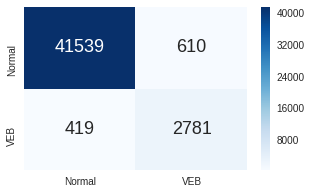

In [91]:
print_confusion_matrix(y_true_test, y_pred_test)

続いて，予測結果の各種スコアを表示してみましょう．

In [92]:
print_scores(y_true_test, y_pred_test)

              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99     42149
         VEB       0.82      0.87      0.84      3200

   micro avg       0.98      0.98      0.98     45349
   macro avg       0.91      0.93      0.92     45349
weighted avg       0.98      0.98      0.98     45349

accuracy:  0.9773093122229818


サンプル数が多い正常拍動に対する予測スコアは高い値を示す一方で，サンプル数の少ないVEBに対しては，スコアが低くなる傾向があります．今回のデータセットのように，サンプルが占めるクラスの割合が極端に偏っている不均衡データでは，こうした傾向がしばしば観測されることが知られています．

次節では，こうしたクラス不均衡問題への対応に加え，ネットワーク構造の改良，前処理の工夫などを行い，予測精度向上に寄与する方法を模索していきます．


## 精度向上に向けて

### クラス不均衡データへの対応

前節でも触れたように，クラス不均衡データを用いて学習器を構築する際，大多数を占めるクラスに偏った予測結果となり，少数のクラスに対して精度が低くなってしまう場合があることが一般的に知られています．一方で，（今回のデータセットを含めて）現実世界のタスクにおいては，大多数の正常サンプルの中に含まれる少数の異常サンプルを精度良く検出することが重要であるというケースは少なくありません．こうした状況において，少数クラスの検出に注目してモデルを学習させる方策が幾つか存在します．

具体的には，
1. サンプリング
    - 不均衡データセットからサンプリングを行い，クラス比率のバランスが取れたデータセットを作成
        - Undersampling : 大多数の正常サンプルを削減
        - Oversampling  : 少数の異常サンプルを水増し
1. 損失関数の重み調整
    - 正常サンプルを異常と誤分類した際のペナルティを小さく，異常サンプルを正常と誤分類した際のペナルティを大きくする．
    - 例：サンプル数の存在比率の逆数を重みとして利用
1. 目的関数(損失関数)の変更
    - 異常サンプルに対する予測スコアを向上させるような目的関数を導入
1. 異常検知
    - 正常サンプルのデータ分布を仮定し，そこから十分に逸脱したサンプルを異常とみなす
    
などの方法があります．本節では，1.のサンプリングと，3.の目的関数の変更の例を紹介していきます．

#### サンプリング




UndersamplingとOversamplingを組み合わせて，データセットの不均衡を解消することを考えます．

今回は以下のステップでサンプリングを行います．

1. Undersamplingにより，正常拍動サンプルのみ1/4に削減 (VEBサンプルは全て残す)
    * ここでは，単純なランダムサンプリングを採用します．ランダム性があるため，分類にとって重要な（VEBサンプルとの識別境界付近にある）サンプルを削除してしまう可能性があります
    * ランダムサンプリングの問題を緩和する手法も幾つか存在しますが，今回は使用しません．
1. Oversamplingにより，Undersampling後の正常拍動サンプルと同数になるまでVEBサンプルを水増し
    * SMOTE (Synthetic Minority Over-sampling TEchnique) という手法を採用します．
    * ランダムにデータを水増しする最も単純な方法だと，過学習を引き起こしやすくなります．SMOTEでは，VEBサンプルと，その近傍VEBサンプルとの間のデータ点をランダムに生成してデータに追加していくことで，過学習の影響を緩和しています．

サンプリングを行うために，以下のSampledECGDatasetクラスを定義します．

また，そのクラスを読み込んで学習用データセットオブジェクトを作成する `create_sampled_train_datset()` 関数を用意します．


In [0]:
from imblearn.datasets import make_imbalance
from imblearn.over_sampling import SMOTE


class SampledECGDataset(ECGDataset):

    def __init__(
            self,
            path
    ):
        super(SampledECGDataset, self).__init__(path)
        _, counts = np.unique(self.y, return_counts=True)
        self.X, self.y = make_imbalance(
            self.X, self.y,
            sampling_strategy={0: counts[0]//4, 1: counts[1]}
        )
        smote = SMOTE(random_state=42)
        self.X, self.y = smote.fit_sample(self.X, self.y)

        
def create_sampled_train_dataset(root_path):
    train_path = os.path.join(root_path, 'preprocessed', 'train')
    train_dataset = SampledECGDataset(train_path)

    return train_dataset

In [0]:
train_dataset = create_sampled_train_dataset(dataset_root)

それでは先程と同様に，trainerを作成して学習を実行してみましょう．(1分程度で学習が完了します．)

In [95]:
trainer = create_trainer(256, train_dataset, nb_epoch=2, device=0)
%time trainer.run()

epoch       iteration   main/loss   main/accuracy
0           7           1.58199     0.655134       
0           14          0.240229    0.912388       
0           21          0.13056     0.952009       
0           28          0.120401    0.954799       
0           35          0.100816    0.962612       
0           42          0.0821277   0.977679       
0           49          0.0639532   0.976562       
0           56          0.039643    0.984933       
0           63          0.0423196   0.984933       
0           70          0.045723    0.984375       
0           77          0.0271234   0.990513       
0           84          0.0339182   0.988839       
1           91          0.0224128   0.991629       
1           98          0.0119512   0.996652       
1           105         0.0102571   0.997768       
1           112         0.00743567  0.997768       
1           119         0.0203054   0.992188       
1           126         0.0149201   0.995536       
1           13

学習が完了したら，評価用データで予測を行い，精度を確認してみましょう．

In [96]:
%time y_true_test, y_pred_test = evaluate(trainer, test_dataset, 256, 0)

CPU times: user 14.9 s, sys: 2.08 s, total: 17 s
Wall time: 16.9 s


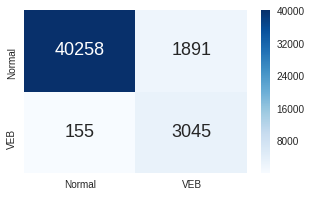

In [97]:
print_confusion_matrix(y_true_test, y_pred_test)

In [98]:
print_scores(y_true_test, y_pred_test)

              precision    recall  f1-score   support

      Normal       1.00      0.96      0.98     42149
         VEB       0.62      0.95      0.75      3200

   micro avg       0.95      0.95      0.95     45349
   macro avg       0.81      0.95      0.86     45349
weighted avg       0.97      0.95      0.96     45349

accuracy:  0.9548832388806809


先程の予測結果と比較して，サンプリングの効果によりVEBサンプルに対する予測精度が向上しているかを確認してみて下さい．

(サンプリングのランダム性や，学習の初期値依存性などの影響があるため，必ず精度向上するとは限らないことにご注意下さい．)

#### 損失関数の変更

続いて，損失関数を変更することで，少数の異常サンプルに対して精度向上させる方法を検討します．少数クラスの予測精度向上に注目した損失関数はこれまでに幾つも提案されていますが，今回はその中で，"Focal loss" という損失関数を利用します．

Focal lossは，画像の物体検知手法の研究論文 [[文献6]](https://arxiv.org/abs/1708.02002) の中で提案された損失関数です．One-stage物体検知手法において，大量の候補領域の中で実際に物体が存在する領域はたかだか数個であることが多く，クラス不均衡なタスクになっており，学習がうまく進まないという問題があります．こうした問題に対処するために提案されたのがfocal lossであり，以下の式によって記述されます．

$$
FL(p_t) = - (1 - p_t)^{\gamma}\log(p_t)
$$

ここで$p_t$はsoftmax関数の出力（確率値）です．$\gamma = 0$の場合，通常のsoftmax cross-entorpy lossと等しくなりますが，$\gamma > 0$の場合，明確に分類可能な（識別が簡単な）サンプルに対して，相対ロスを小さくする効果があります．その結果，分類が難しいサンプルにより注目して学習が進んでいくことが期待されます．

下図は，正解クラスの予測確率値と，その際のlossの関係をプロットしており，$\gamma$の値を変化させた場合に，相対ロスがどのように下がっていくかを示しています．

![focal_plot](https://github.com/japan-medical-ai/medical-ai-course-materials/raw/master/notebooks/images/monitoring/focal_plot.png)

(図は [[文献6]](https://arxiv.org/abs/1708.02002)より抜粋)

それでは実際に，Focal loss関数を定義してみましょう．

In [0]:
from chainer.backends.cuda import get_array_module

def focal_loss(x, t, class_num=2, gamma=1.0, eps=1e-6):
    xp = get_array_module(t)

    p = F.softmax(x)
    p = F.clip(p, x_min=eps, x_max=1-eps)
    log_p = F.log_softmax(x)
    t_onehot = xp.eye(class_num)[t.ravel()]

    loss_sce = -1 * t_onehot * log_p
    loss_focal = F.sum(loss_sce * (1. - p) ** gamma, axis=1)

    return F.mean(loss_focal)

前項目で実施したデータサンプリングは行わず，初回の学習時と同様の設定にした上で，損失関数をfocal lossに変更します．

In [0]:
train_dataset = create_train_dataset(dataset_root)

In [0]:
trainer = create_trainer(256, train_dataset, nb_epoch=1, device=0, lossfun=focal_loss)

それでは学習を開始しましょう．(1分30秒ほどで学習が完了します．)

In [102]:
%time trainer.run()

epoch       iteration   main/loss   main/accuracy
0           7           0.981516    0.851562       
0           14          0.234755    0.920201       
0           21          0.149996    0.930804       
0           28          0.0964392   0.956473       
0           35          0.0820904   0.953683       
0           42          0.0517503   0.973772       
0           49          0.0355474   0.982701       
0           56          0.0364314   0.980469       
0           63          0.0358608   0.985491       
0           70          0.0274834   0.984375       
0           77          0.0307082   0.984375       
0           84          0.0243667   0.988281       
0           91          0.0287891   0.989397       
0           98          0.0260664   0.988839       
0           105         0.0216717   0.989955       
0           112         0.0251307   0.988281       
0           119         0.020206    0.991629       
0           126         0.0238549   0.989955       
0           13

学習が完了したら，評価用データにて予測結果を確認してみましょう．

In [103]:
%time y_true_test, y_pred_test = evaluate(trainer, test_dataset, 256, 0)

CPU times: user 14.8 s, sys: 1.88 s, total: 16.7 s
Wall time: 16.6 s


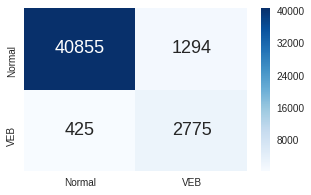

In [104]:
print_confusion_matrix(y_true_test, y_pred_test)

In [105]:
print_scores(y_true_test, y_pred_test)

              precision    recall  f1-score   support

      Normal       0.99      0.97      0.98     42149
         VEB       0.68      0.87      0.76      3200

   micro avg       0.96      0.96      0.96     45349
   macro avg       0.84      0.92      0.87     45349
weighted avg       0.97      0.96      0.96     45349

accuracy:  0.9620939822267305


初期モデルの予測結果と，今回の予測結果を比較してみて下さい．

（余力があれば，$\gamma$の値を変化させた場合に，予測結果にどのような影響があるか確認してみて下さい．）

### ネットワーク構造の変更

続いて，学習に用いるネットワーク構造を変更することを検討します．

ここでは，最初に用いたResNet34構造に対して以下の拡張を行います．
1. 1D Convolutionを，1D Dilated Convolutionに変更
    - Dilated Convolutionを用いることで，パラメータ数の増大を抑えながら，より広範囲の特徴を抽出可能になると期待されます（遺伝子解析の際と同様のモチベーション）．
    - 広範囲の特徴が重要でないタスクの場合には，精度向上に繋がらない（ or 場合によっては精度が低下する）可能性もあります．
1. 最終層の手前に全結合層を追加し，Dropoutを適用
    - Dropoutを行うことで，学習器の汎化性能が向上することを期待します．ただし，複数の先行研究([[文献6](https://arxiv.org/abs/1506.02158v6)]など)において，単純に畳み込み層の直後にDropoutを適用するだけでは汎化性能の向上が期待出来ないと報告されていることから，今回は全結合層に適用することにします．
    
それでは，上記の拡張を加えたネットワークを定義しましょう．（ResBlockクラスは，初期モデル構築時に定義済み）
   

In [0]:
class DilatedResNet34(chainer.Chain):

    def __init__(self):
        super(DilatedResNet34, self).__init__()
        with self.init_scope():
            self.conv1 = L.ConvolutionND(1, None, 64, 7, 2, 3)
            self.bn1 = L.BatchNormalization(64)
            self.resblock0 = ResBlock(64, 3, 1)
            self.resblock1 = ResBlock(128, 4, 1)
            self.resblock2 = ResBlock(256, 6, 2)
            self.resblock3 = ResBlock(512, 3, 4)
            self.fc1 = L.Linear(None, 512)
            self.fc2 = L.Linear(None, 2)

    def __call__(self, x):
        h = F.relu(self.bn1(self.conv1(x)))
        h = F.max_pooling_nd(h, 3, 2)
        for i in range(4):
            h = getattr(self, 'resblock{}'.format(str(i)))(h)
        h = F.average(h, axis=2)
        h = F.dropout(self.fc1(h), 0.5)
        h = self.fc2(h)
        return h
      

ネットワーク構造を除いて，全て初期モデルと同様の設定で学習を行います．

In [0]:
def create_trainer(
    batchsize, train_dataset, nb_epoch=1,
    device=0, lossfun=F.softmax_cross_entropy
):
    # setup model
    model = DilatedResNet34()
    train_model = Classifier(model, lossfun=lossfun)

    # use Adam optimizer
    optimizer = optimizers.Adam(alpha=0.001)
    optimizer.setup(train_model)
    optimizer.add_hook(WeightDecay(0.0001))

    # setup iterator
    train_iter = MultiprocessIterator(train_dataset, batchsize)

    # define updater
    updater = training.StandardUpdater(train_iter, optimizer, device=device)

    # setup trainer
    stop_trigger = (nb_epoch, 'epoch')
    trainer = training.trainer.Trainer(updater, stop_trigger)
    logging_attributes = [
        'epoch', 'iteration',
        'main/loss', 'main/accuracy'        
    ]
    trainer.extend(
        extensions.LogReport(logging_attributes, trigger=(2000 // batchsize, 'iteration'))
    )
    trainer.extend(
        extensions.PrintReport(logging_attributes)
    )
    trainer.extend(
        extensions.ExponentialShift('alpha', 0.75, optimizer=optimizer),
        trigger=(4000 // batchsize, 'iteration')
    )

    return trainer

In [0]:
train_dataset = create_train_dataset(dataset_root)
test_dataset = create_test_dataset(dataset_root)

In [0]:
trainer = create_trainer(256, train_dataset, nb_epoch=1, device=0)

それでは，これまでと同様に学習を開始しましょう．(1分30秒ほどで学習が完了します．)

In [110]:
%time trainer.run()

epoch       iteration   main/loss   main/accuracy
0           7           1.12984     0.853237       
0           14          0.337393    0.923549       
0           21          0.227592    0.921317       
0           28          0.30414     0.929688       
0           35          0.145865    0.942522       
0           42          0.0994738   0.960379       
0           49          0.0838294   0.967076       
0           56          0.0948459   0.967076       
0           63          0.0700816   0.979353       
0           70          0.0547348   0.978795       
0           77          0.0466978   0.989397       
0           84          0.037644    0.989955       
0           91          0.0376686   0.990513       
0           98          0.0526526   0.986607       
0           105         0.0325144   0.988281       
0           112         0.0260394   0.992188       
0           119         0.0271366   0.992188       
0           126         0.018607    0.99442        
0           13

学習が完了したら，評価用データで予測を行い，精度を確認してみましょう．

In [111]:
%time y_true_test, y_pred_test = evaluate(trainer, test_dataset, 256, 0)

CPU times: user 15 s, sys: 1.68 s, total: 16.7 s
Wall time: 16.6 s


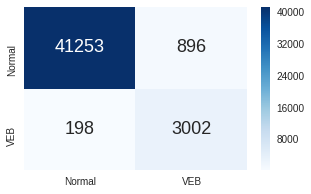

In [112]:
print_confusion_matrix(y_true_test, y_pred_test)

In [113]:
print_scores(y_true_test, y_pred_test)

              precision    recall  f1-score   support

      Normal       1.00      0.98      0.99     42149
         VEB       0.77      0.94      0.85      3200

   micro avg       0.98      0.98      0.98     45349
   macro avg       0.88      0.96      0.92     45349
weighted avg       0.98      0.98      0.98     45349

accuracy:  0.9758759840349291


初期モデルの予測結果と，今回の予測結果を比較してみて下さい．

### ノイズ除去の効果検証

最後に，心電図に含まれるノイズの除去について検討します．

心電図波形には，以下のような外部ノイズが含まれている可能性があります．
* 高周波
    * 筋電図ノイズ (Electromyogram noise)
        - 体動により，筋肉の電気的活動が心電図に混入する場合があります．
    * 電力線誘導障害 (Power line interference)
        - 静電誘導により交流電流が流れ込み，心電図に混入する場合があります．
        - 電源配線に電流が流れることで磁力線が発生し，電磁誘導作用により交流電流が流れ込む場合があります．
    * 加算性白色ガウスノイズ (Additive white Gaussian noise)
        - 外部環境に由来する様々な要因でホワイトノイズが混入してきます．
* 低周波
    * 基線変動 (Baseline wandering)
        - 電極の装着不良，発汗，体動などの影響で，基線がゆっくり変動する場合があります．

心電図を解析する際は，頻脈や徐脈などの異常波形を正確に判別するために，上記のようなノイズを除去する前処理が行われるのが一般的です．

ノイズを除去する方法は幾つかありますが，最も単純なのは，線形フィルタを適用する方法です．今回は線形フィルタの一つであるバターワースフィルタを用いて，ノイズ除去を試してみましょう．

BaseECGDatasetPreprocessorにシグナルノイズ除去の機能を追加した，DenoiseECGDatasetPreprocessorクラスを定義します．

In [0]:
from scipy.signal import butter, lfilter


class DenoiseECGDatasetPreprocessor(BaseECGDatasetPreprocessor):

    def __init__(
            self,
            dataset_root='./',
            window_size=720
    ):
        super(DenoiseECGDatasetPreprocessor, self).__init__(
        dataset_root, window_size)

    def _denoise_signal(
            self,
            signal,
            btype='low',
            cutoff_low=0.2,
            cutoff_high=25.,
            order=5
    ):
        nyquist = self.sample_rate / 2.
        if btype == 'band':
            cut_off = (cutoff_low / nyquist, cutoff_high / nyquist)
        elif btype == 'high':
            cut_off = cutoff_low / nyquist
        elif btype == 'low':
            cut_off = cutoff_high / nyquist
        else:
            return signal
        b, a = butter(order, cut_off, analog=False, btype=btype)
        return lfilter(b, a, signal)

    def _segment_data(
            self,
            signal,
            symbols,
            positions
    ):
        X = []
        y = []
        sig_len = len(signal)
        for i in range(len(symbols)):
            start = positions[i] - self.window_size // 2
            end = positions[i] + self.window_size // 2
            if symbols[i] in self.valid_symbols and start >= 0 and end <= sig_len:
                segment = signal[start:end]
                assert len(segment) == self.window_size, "Invalid length"
                X.append(segment)
                y.append(self.labels.index(self.label_map[symbols[i]]))
        return np.array(X), np.array(y)

    def prepare_dataset(
            self,
            denoise=False,
            normalize=True
    ):
        if not os.path.isdir(self.download_dir):
            self.download_data()

        # prepare training dataset
        self._prepare_dataset_core(self.train_record_list, "train", denoise, normalize)
        # prepare test dataset
        self._prepare_dataset_core(self.test_record_list, "test", denoise, normalize)

    def _prepare_dataset_core(
            self,
            record_list,
            mode="train",
            denoise=False,
            normalize=True
    ):
        Xs, ys = [], []
        for i in range(len(record_list)):
            signal, symbols, positions = self._load_data(record_list[i])
            if denoise:
                signal = self._denoise_signal(signal)
            if normalize:
                signal = self._normalize_signal(signal)
            X, y = self._segment_data(signal, symbols, positions)
            Xs.append(X)
            ys.append(y)
        os.makedirs(os.path.join(self.dataset_root, 'preprocessed', mode), exist_ok=True)
        np.save(os.path.join(self.dataset_root, 'preprocessed', mode, "X.npy"),
                np.vstack(Xs))
        np.save(os.path.join(self.dataset_root, 'preprocessed', mode, "y.npy"),
                np.concatenate(ys))


線形フィルタを適用することで，学習モデルが異常拍動のパターンを特徴として捉えやすくなる可能性があります．一方で，異常拍動を検出するにあたって重要な情報も除去されてしまう可能性があることに注意してください．

mitdbでは，予め0.1 Hz 以下の低周波と，100 Hz 以上の高周波をバンドパスフィルタによって除去済みであるため，ここではさらに，25 Hz のローパス・バターワースフィルタによって高周波ノイズを取り除きます．

それでは，ノイズ除去オプションを有効にして，前処理を実行してみましょう．

In [0]:
DenoiseECGDatasetPreprocessor(dataset_root).prepare_dataset(denoise=True)

実際に，高周波ノイズ除去後の波形を可視化してみましょう．

In [0]:
X_train_d = np.load(os.path.join(dataset_root, 'preprocessed', 'train', 'X.npy'))

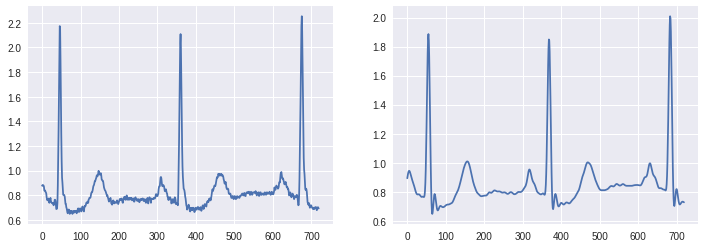

In [138]:
plt.subplots(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(X_train[idx_n[0]])
plt.subplot(1, 2, 2)
plt.plot(X_train_d[idx_n[0]])
plt.show()

左図がフィルタリング前の波形、右図がフィルタリング後の波形です．
細かな振動が取り除かれていることが確認できると思います．

これまでと同様に，ノイズ除去後のデータを用いて学習を行ってみましょう．(1分30秒ほどで学習が完了します．)

In [0]:
train_dataset = create_train_dataset(dataset_root)
test_dataset = create_test_dataset(dataset_root)

In [140]:
trainer = create_trainer(256, train_dataset, nb_epoch=1, device=0)
%time trainer.run()

epoch       iteration   main/loss   main/accuracy
0           7           2.24028     0.80692        
0           14          0.328245    0.916853       
0           21          0.360923    0.913504       
0           28          0.163021    0.93192        
0           35          0.141234    0.928571       
0           42          0.129063    0.949777       
0           49          0.0941628   0.965402       
0           56          0.0742349   0.978237       
0           63          0.335941    0.978237       
0           70          0.0603929   0.986607       
0           77          0.0421011   0.982701       
0           84          0.0385519   0.989397       
0           91          0.0233245   0.991629       
0           98          0.0455289   0.985491       
0           105         0.0246131   0.993862       
0           112         0.0383148   0.991071       
0           119         0.0293103   0.991071       
0           126         0.0343781   0.989397       
0           13

学習が完了したら，評価用データで予測を行い，精度を確認してみましょう．

In [141]:
%time y_true_test, y_pred_test = evaluate(trainer, test_dataset, 256, 0)

CPU times: user 15 s, sys: 1.88 s, total: 16.9 s
Wall time: 16.9 s


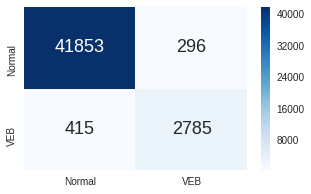

In [142]:
print_confusion_matrix(y_true_test, y_pred_test)

In [143]:
print_scores(y_true_test, y_pred_test)

              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99     42149
         VEB       0.90      0.87      0.89      3200

   micro avg       0.98      0.98      0.98     45349
   macro avg       0.95      0.93      0.94     45349
weighted avg       0.98      0.98      0.98     45349

accuracy:  0.9843215947429932


高周波のノイズを除去したことで，予測精度がどのように変わったか確認してみましょう．

## おわりに

本章では，ECGの公開データセットを利用して，不整脈検知の問題に取り組みました．

本講義内容を通じてお伝えしたかったことは，以下となります．
1. 心電図を解析するにあたって必要となる最低限の知識
1. モニタリングデータを解析するための基本的な前処理手順
1. CNNベースのモデルを利用した学習器の構築
1. データセットの性質を考慮した学習方法や前処理の工夫

また，精度向上に向けて様々な手法を試してみましたが，現実世界のタスクにおいては，どの工夫が有効に働くか自明で無い場合がほとんどです．従って，試行錯誤を行いながら，その問題設定に適合するやり方を模索していく必要があります．

さらなる取り組みとしては，例えば下記内容を検討する余地があります．
* 情報の追加
    * $Ⅱ$誘導シグナルに加えて，$V_1$誘導シグナルも同時に入力として与える．
* 前処理の工夫
    * セグメント長の変更
        * より長時間のセグメントを入力として，長期的な特徴を抽出する．
    * ラベルの追加
        * Normal，VEBに加えて，SVEB（上室異所性拍動）等も使用する．
    * ラベルの与え方の変更
        * セグメント範囲内に正常以外のピークラベルが含まれる場合に優先的にそのラベルを付与する，等．
* モデルの変更
    * 長期的な特徴を抽出するために，CNNの後段にRNNベースの構造(LSTM, GRUなど)を組み込む．


余力がある方は，是非チャレンジしてみてください．

以上で，モニタリングデータの時系列解析の章は終了となります．お疲れ様でした．